 0001145924 Fabio Giordana fabio.giordana@studio.unibo.it

 0001113225 Abdul Moqeet abdul.moqeet@studio.unibo.it

# **Product Recognition of Food Products**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it


Computer vision-based object detection techniques can be applied in super market settings to build a system that can identify products on store shelves.
An example of how this system could be used would be to assist visually impaired customers or automate common store management tasks like detecting low-stock or misplaced products, given an image of a shelf in a store.

## Task
Develop a computer vision system that, given a reference image for each product, is able to identify such product from one picture of a store shelf.

<figure>
<a href="https://imgbb.com/">
  <center>
  <img src="https://i.ibb.co/TwkMWnH/Screenshot-2024-04-04-at-14-54-51.png" alt="Screenshot-2024-04-04-at-14-54-51" border="0" width="300" />
</a>
</figure>

For each type of product displayed in the
shelf the system should report:
1. Number of instances;
1. Dimension of each instance (width and height in pixel of the bounding box that enclose them);
1. Position in the image reference system of each instance (center of the bounding box that enclose them).

#### Example of expected output
```
Product 0 - 2 instance found:
  Instance 1 {position: (256, 328), width: 57px, height: 80px}
  Instance 2 {position: (311, 328), width: 57px, height: 80px}
Product 1 – 1 instance found:
.
.
.
```

### Track A - Single Instance Detection
Develop an object detection system to identify single instance of products given one reference image for each item and a scene image.

The system should be able to correctly identify all the product in the shelves
image.

### Track B - Multiple Instances Detection
In addition to what achieved at step A, the system should also be able to detect multiple instances of the same product.

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify.
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios. The images contained in this folder are corrupted by noise.

#### Track A - Single Instance Detection
* **Models**: {ref1.png to ref14.png}.
* **Scenes**: {scene1.png to scene5.png}.

#### Track B - Multiple Instances Detection
* **Models**: {ref15.png to ref27.png}.
* **Scenes**: {scene6.png to scene12.png}.

## Evaluation criteria
1. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

2. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed approach.

In [18]:
from google.colab import drive
drive.mount('/content/drive')

!ls /content/drive/MyDrive

!cp -r /content/drive/MyDrive/dataset.zip ./

!unzip dataset.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Assignement1IPCV.ipynb  'Colab Notebooks'   data   dataset.zip
Archive:  dataset.zip
replace __MACOSX/._dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: __MACOSX/._dataset      
  inflating: __MACOSX/dataset/._scenes  
  inflating: dataset/.DS_Store       
  inflating: __MACOSX/dataset/._.DS_Store  
  inflating: __MACOSX/dataset/._models  
  inflating: dataset/scenes/scene12.png  
  inflating: __MACOSX/dataset/scenes/._scene12.png  
  inflating: dataset/scenes/scene10.png  
  inflating: __MACOSX/dataset/scenes/._scene10.png  
  inflating: dataset/scenes/scene11.png  
  inflating: __MACOSX/dataset/scenes/._scene11.png  
  inflating: dataset/scenes/scene5.png  
  inflating: __MACOSX/dataset/scenes/._scene5.png  
  inflating: dataset/scenes/scene4.png  
  inflating: __MACOSX/dataset/scenes/._scene4.png  
  inflating: dataset/scenes/scene6.png  
  i

**IMAGE DENOISING**

Since the scene images are heavily affected by different forms of noise, we implemented a denoising pipeline composed by:


*   Median Filter with a kernel size of 9, to remove as much impulse noise as possible. We used a quite large kernel size, leading to a strong denoising effect, due to the great presence of this type of noise in the images.

*   Bilateral Filter with a kernel size of 5 and a sigma of 75, to reduce noise while keeping sharp edges. We selected this filter instead of faster alternatives (computationally speaking) since it is used in an offline application.

*   Non-Local-Means filter for colored images, to further remove noise from the scene images keeping into account that they are colored, while still preserving important details.








In [19]:
#import of useful libraries

import numpy as np
import cv2
from matplotlib import pyplot as plt

In [20]:
def clean_image(img):
  """ Denoise the scene images

  Args:
      img : scene image

  Returns: denoised image
  """
  img = cv2.medianBlur(img, 9)
  img = cv2.bilateralFilter(img,5,75,75)
  img = cv2.fastNlMeansDenoisingColored(img)
  return img

In [21]:
def load_scenes(url="dataset/scenes/scene"):
  """ Load the scene images

  Args:
      url : path to the folder containing the scene images

  Returns: list of scene images
  """
  scenes = []
  for i in range(1, 13):
    scene = cv2.imread(url + str(i) + ".png")[:,:,::-1]
    scene = clean_image(scene)
    scenes.append(scene)
  return scenes

In [22]:
def load_refs(url="dataset/models/ref"):
  """ Load the reference images

  Args:
      url : path to the folder containing the reference images

  Returns: list of reference images
  """
  refs = []
  for i in range(1, 28):
    ref = cv2.imread(url + str(i) + ".png")[:,:,::-1]
    refs.append(ref)
  return refs

**Product Detection**

Here we describe the pipeline for product detection performed in this notebook for each scene image.

*   First, we apply the SIFT feature detector and descriptor on the scene image and on all the references images. Then we match the keypoints between the scene and all the references. To discard low quality matches, we apply the Lowe's ratio criterion for the distances.
*   Based on the number of matches, we select the best candidate between all the references. It must also have a number of good matches higher than a given threshold.
*  The matches of the best candidate (if one exists) are used to compute an homography to then map the reference into the scene image.

At this point, to further increase the performances of the product detector, we add additional checks before considering the match an actual detected product and add it to the results.

*   We check if the found bounding box is actually inside the image and have sound values for its edges. Furthermore, we check that the ratio between width and height of the box is similar to the ratio of the reference image, since this is a feature which is invariant to scaling. The confidence interval to check this similarity is a parameter that we fine tuned to obtain the best performances.
*   Since SIFT, as it is implemented in opencv (https://github.com/opencv/opencv/blob/e96a58f09124bb5ae22cfa036c91c24e1d767f63/modules/features2d/src/sift.dispatch.cpp#L145), works converting the image in gray scale, we introduce a color similarity check between the reference and the content of the bounding box, computing the color histogram similarity over the A and B channels of the images converted to LAB, similarly to what is done at https://docs.opencv.org/3.4/d8/dc8/tutorial_histogram_comparison.html
and then finetuning the threshold.

After that a positive match is found (even if it does not result in an actual detected product) we remove the scene keypoints used during this process and repeat the pipeline above from the matching part, selecting a new candidate. We repeat this method until no good candidate is found between all the referneces or after that three consecutive candidate are discarded by the successive controls.








In [23]:
def compute_color_histogram(image):
    """ Compute the color histogram of an image over the A and B channels of LAB

    Args:
        image : image

    Returns: color histogram
    """
    lab_patch = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    hist_a = cv2.calcHist([lab_patch], [1], None, [256], [-128, 127])
    hist_b = cv2.calcHist([lab_patch], [2], None, [256], [-128, 127])

    hist_a = cv2.normalize(hist_a, hist_a)
    hist_b = cv2.normalize(hist_b, hist_b)

    return np.concatenate([hist_a, hist_b])

In [24]:
def detect_features(sift, img):
  """ Detect features and compute descriptors

  Args:
      sift : SIFT detector
      img : image

  Returns: keypoints and descriptors
  """
  return sift.detectAndCompute(img, None)

In [25]:
def match_features(des_scene, des_ref):
    """ Match features between scene and reference

    Args:
        des_scene : scene descriptors
        des_ref : reference descriptors

    Return: list of good matches
    """
    FLANN_INDEX_KDTREE = 1

    # Defining parameters for algorithm
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

    # Defining search params.
    # checks=50 specifies the number of times the trees in the index should be recursively traversed.
    # Higher values gives better precision, but also takes more time
    search_params = dict(checks = 250)

    # Initializing matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Matching and finding the 2 closest elements for each query descriptor.

    matches = flann.knnMatch(np.float32(des_scene),np.float32(des_ref),k=2)

    good_matches = []
    for m,n in matches:
      if m.distance < 0.7*n.distance:
        good_matches.append(m)

    return good_matches


In [26]:
def remove_matches(kp_scene, des_scene, rectangle):
  """Remove the keypoints of the scene inside the bounding box
  Args:
      kp_scene : scene keypoints
      des_scene : scene descriptors
      rectangle : bounding box

  Returns: filtered keypoints and descriptors
  """
  filtered_keypoints = []
  filtered_descriptors = []
  contour = np.array(rectangle, dtype=np.int32)
  for i, kp in enumerate(kp_scene):
        x, y = kp.pt
        if cv2.pointPolygonTest(contour, (x, y), False) < 0:
            filtered_keypoints.append(kp)
            filtered_descriptors.append(des_scene[i])

  return filtered_keypoints, filtered_descriptors

In [27]:
def remove_inliers(kp_scene, des_scene, mask, matches):
  """Remove the keypoints used to compute the homography by appling the mask returned by the opencv method findHomography
  Args:
      kp_scene : scene keypoints
      des_scene : scene descriptors
      mask : mask returned by the opencv method findHomography
      matches : list of matches

  Returns: filtered keypoints and descriptors
  """
  inliers = mask.ravel() == 1
  filtered_kp = [kp_scene[m.queryIdx] for i, m in enumerate(matches) if not inliers[i]]
  filtered_des =  [des_scene[m.queryIdx] for i, m in enumerate(matches) if not inliers[i]]
  return filtered_kp, filtered_des

In [28]:
def check_ratio(x_min, x_max, y_min, y_max, ref_w, ref_h, ratio_treshold):
    """ Check if the ratio of the bounding box is similar to the ratio of the reference image
    Args:
        x_min : minimum x coordinate of the bounding box
        x_max : maximum x coordinate of the bounding box
        y_min : minimum y coordinate of the bounding box
        y_max : maximum y coordinate of the bounding box
        ref_w : width of the reference image
        ref_h : height of the reference image
        ratio_treshold : confidence interval

    Returns: True if the ratio is similar, False otherwise
    """
    small_ref_side = min(ref_w, ref_h)
    large_ref_side = max(ref_w, ref_h)
    expected_ratio = small_ref_side/large_ref_side

    width = x_max - x_min
    height = y_max - y_min

    small_side = min(width, height)
    large_side = max(width, height)

    if small_side == 0:
        return False

    scene_ratio = small_side/large_side
    lower_bound = expected_ratio * (1 - ratio_treshold)
    upper_bound = expected_ratio * (1 + ratio_treshold)

    return lower_bound <= scene_ratio <= upper_bound

In [29]:
def draw_matches(scene, kp_scene, des_scene, ref, kp_ref, good_matches, sim_treshold, ratio_treshold):
  """ Compute the bounding box of the selected reference image and perform the additional checks over bounding box ratio and color similarity
  Args:
      scene : scene image
      kp_scene : scene keypoints
      des_scene : scene descriptors
      ref : reference image
      kp_ref : reference keypoints
      good_matches : list of good matches
      sim_treshold : confidence interval for the color similarity check
      ratio_treshold : confidence interval for the ratio check

  Returns: filtered keypoints and descriptors, plus a fail flag and the position of the bounding box (if the product is actually detected)
  """

  src_pts = np.float32([kp_scene[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
  dst_pts = np.float32([kp_ref[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)
  M, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC)
  if M is None:
    kp_scene, des_scene = remove_inliers(kp_scene, des_scene, mask, good_matches)
    return kp_scene, des_scene, True, None
  h,w = ref.shape[:2]
  pts = np.float32([[0,0],[0,h-1],[w-1,h-1],[w-1,0]]).reshape(-1,1,2)
  dst = cv2.perspectiveTransform(pts,M)
  x_min = int(max(0,min(dst[:,0,0])))
  x_max = int(min(max(dst[:,0,0]), scene.shape[1]-1))
  y_min = int(max(0,min(dst[:,0,1])))
  y_max = int(min(max(dst[:,0,1]), scene.shape[0]-1))
  if x_min < 0 or x_min>=scene.shape[1] or x_max <0 or x_max >= scene.shape[1] or y_min < 0 or y_min >= scene.shape[0] or y_max <0 or y_max >= scene.shape[0]:
    kp_scene, des_scene = remove_inliers(kp_scene, des_scene, mask, good_matches)
    kp_scene, des_scene = remove_matches(kp_scene, des_scene, np.array(dst, dtype=np.int32))
    return kp_scene, des_scene, True, None
  center = np.array([x_min+((x_max-x_min)/2), y_min+((y_max-y_min)/2)], dtype=np.int32)
  scene_patch = scene[y_min:y_max, x_min:x_max]
  hist_scene_patch = compute_color_histogram(scene_patch)
  hist_ref = compute_color_histogram(ref)
  similarity = cv2.compareHist(hist_scene_patch, hist_ref, cv2.HISTCMP_BHATTACHARYYA)
  fail = True
  position = None
  if similarity < sim_treshold and check_ratio(x_min, x_max, y_min, y_max, w, h, ratio_treshold):
    fail = False
    scene = cv2.rectangle(scene, (x_max, y_max), (x_min, y_min), (255,0,0), 10, cv2.LINE_AA)
    scene = cv2.circle(scene, np.int32(center), 5, (255,0,0), -1, cv2.LINE_AA)
    width = x_max - x_min
    height = y_max - y_min
    position = f"position: ({center[0]}, {center[1]}), width: {width}px, height: {height}px"
  kp_scene, des_scene = remove_matches(kp_scene, des_scene, np.array(dst, dtype=np.int32))
  return kp_scene, des_scene, fail, position

In [30]:
def print_results(results):
  """ Print the results of the product detection for one scene image
  Args:
      results : dictionary containing the results of the product detection
  """
  for product in results:
    print()
    print("Product", product, ":", len(results[product]), "instances found:")
    for i, position in enumerate(results[product]):
      print("Instance", i+1, "at ", position)

In [31]:
def multiple_detection(scene_number, scene, kp_scene, des_scene, refs, sift, treshold, sim_treshold, ratio_treshold, multiple=False):
  """" Main method for the product detection. It finds the best candidate between the references and it calls the method to compute
  the bounding box of the selected reference image and perform the additional checks over bounding box ratio and color similarity
  Args:
      scene_number : number of the scene image
      scene : scene image
      kp_scene : scene keypoints
      des_scene : scene descriptors
      refs : list of reference images
      sift : SIFT detector
      threshold: treshold for the number of good matches
      sim_treshold : confidence interval for the color similarity check
      ratio_treshold : confidence interval for the ratio check
      multiple : flag to indicate if the method is called for multiple instance detection (used to print the right number for identifying references)
  """

  d = {}
  results = {}
  for i, ref in enumerate(refs, start=0):
    kp_ref, des_ref = detect_features(sift, ref)
    d[i] = [kp_ref, des_ref]
  fails_count = 0
  print("-----------------------------------------------------------------------")
  print("-----------------------------------------------------------------------")
  print("Searching products in scene ", scene_number)
  while True:
    best_candidate = None
    number_of_matches = 0
    for key in d:
      kp_ref = d[key][0]
      des_ref = d[key][1]
      good_matches = match_features(des_scene, des_ref)
      if len(good_matches) > number_of_matches:
          best_candidate = (key, kp_ref, des_ref, good_matches)
          number_of_matches = len(good_matches)
    if best_candidate is not None and number_of_matches > treshold:
      ref = refs[best_candidate[0]]
      kp_ref = best_candidate[1]
      des_ref = best_candidate[2]
      good_matches = best_candidate[3]
      kp_scene, des_scene, fail, position = draw_matches(scene, kp_scene, des_scene, ref, kp_ref, good_matches, sim_treshold, ratio_treshold)
      if fail:
        fails_count = fails_count + 1
        if fails_count == 3:
          print_results(results)
          print()
          plt.imshow(scene)
          plt.show()
          return
      else:
        if multiple:
          ref_number = best_candidate[0]+15
        else:
          ref_number = best_candidate[0]+1
        if ref_number in results:
          results[ref_number].append(position)
        else:
          results[ref_number] = [position]
    else:
      print_results(results)
      print()
      plt.imshow(scene)
      plt.show()
      return

**SINGLE INSTANCE DETECTION**

We were able to perform both single instance detection and multiple instance detection with the same method, by just finetuning differently the threshold values for minimum number of matches, bounding box ratio and color similarity confidence. This can be motivated by the fact that for single instance detection, we want more strict controls to avoid any false positive, while in multiple instance detection we are more concerned about missing an actual product.

In [32]:
scenes = load_scenes()
refs = load_refs()

-----------------------------------------------------------------------
-----------------------------------------------------------------------
Searching products in scene  1

Product 1 : 1 instances found:
Instance 1 at  position: (413, 537), width: 805px, height: 1052px

Product 2 : 1 instances found:
Instance 1 at  position: (1247, 534), width: 804px, height: 1050px



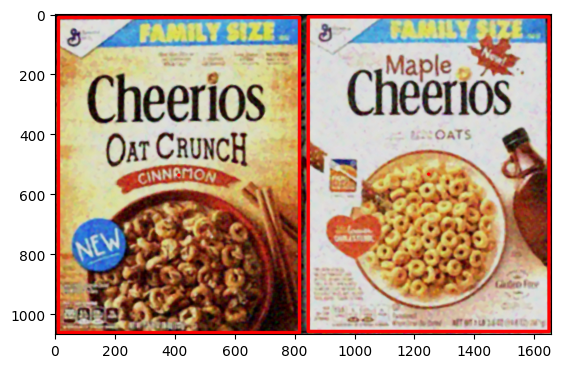

-----------------------------------------------------------------------
-----------------------------------------------------------------------
Searching products in scene  2

Product 3 : 1 instances found:
Instance 1 at  position: (303, 492), width: 607px, height: 943px

Product 5 : 1 instances found:
Instance 1 at  position: (1528, 450), width: 562px, height: 844px

Product 4 : 1 instances found:
Instance 1 at  position: (926, 482), width: 633px, height: 949px



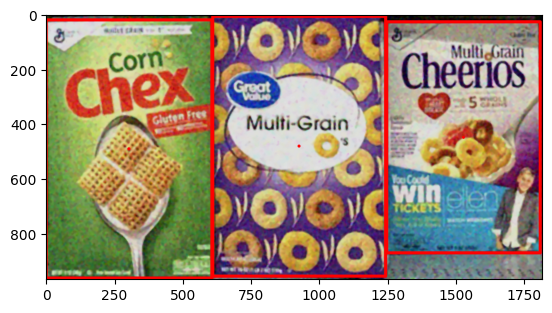

-----------------------------------------------------------------------
-----------------------------------------------------------------------
Searching products in scene  3

Product 8 : 1 instances found:
Instance 1 at  position: (1447, 396), width: 560px, height: 785px

Product 7 : 1 instances found:
Instance 1 at  position: (888, 459), width: 550px, height: 652px

Product 6 : 1 instances found:
Instance 1 at  position: (299, 455), width: 598px, height: 668px



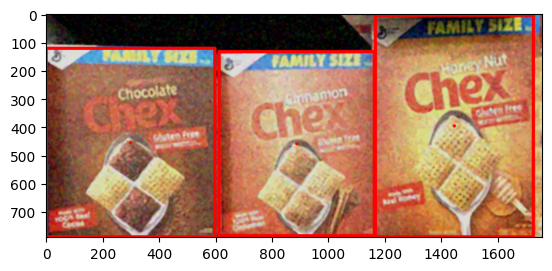

-----------------------------------------------------------------------
-----------------------------------------------------------------------
Searching products in scene  4

Product 1 : 1 instances found:
Instance 1 at  position: (887, 913), width: 385px, height: 516px

Product 8 : 1 instances found:
Instance 1 at  position: (350, 258), width: 350px, height: 494px

Product 10 : 1 instances found:
Instance 1 at  position: (937, 294), width: 269px, height: 401px

Product 9 : 1 instances found:
Instance 1 at  position: (174, 939), width: 330px, height: 467px



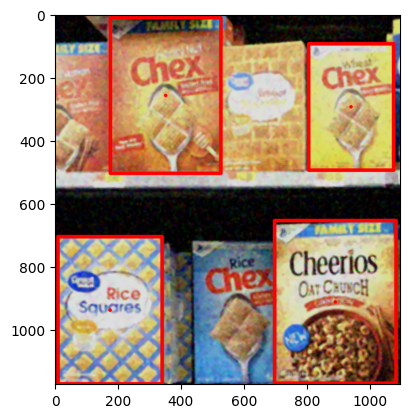

-----------------------------------------------------------------------
-----------------------------------------------------------------------
Searching products in scene  5

Product 11 : 1 instances found:
Instance 1 at  position: (368, 752), width: 368px, height: 554px

Product 12 : 1 instances found:
Instance 1 at  position: (715, 736), width: 442px, height: 657px



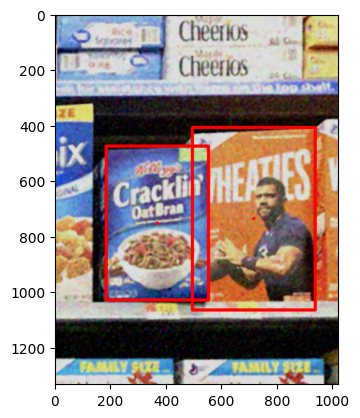

In [33]:
for i, scene in enumerate(scenes[0:5]):
  sift = cv2.SIFT_create()
  kp_scene, des_scene = detect_features(sift, scene)
  multiple_detection(i+1, scene, kp_scene, des_scene, refs[0:14], sift, 30, 0.5, 0.1)

**MULTIPLE INSTANCE DETECTION**

A trend that we noticed is that it seems to be easier to find good matches when it comes to references containing blue or red, rather than very similar images containing mainly yellow, probably because of how the contrasts appear once converted in gray scale by SIFT. While we were able to fix this issue for most of the scenes by finetuning the thresholds and the denoising parameters, the application still confuses one instance of product 24 with 23 in scene 11.

The other errors we encountered seem to be related to reference images with simpler designs just differing beetwen them for the color, probably leading to a reduced number of keypoints detected by SIFT and a lower quality matches, leading to a wrong detection, like in image 8 or to a missed detection, like in image 9 and 12.


-----------------------------------------------------------------------
-----------------------------------------------------------------------
Searching products in scene  6

Product 15 : 2 instances found:
Instance 1 at  position: (582, 619), width: 327px, height: 904px
Instance 2 at  position: (187, 618), width: 339px, height: 906px



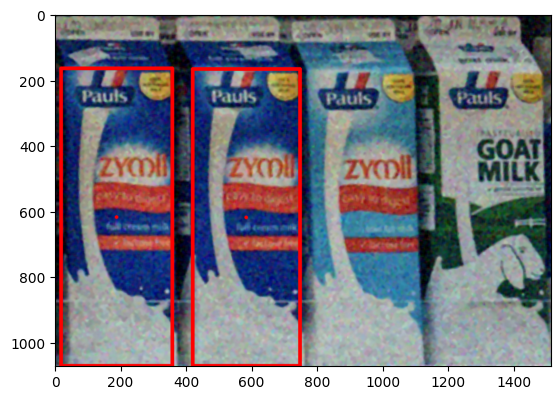

-----------------------------------------------------------------------
-----------------------------------------------------------------------
Searching products in scene  7

Product 16 : 2 instances found:
Instance 1 at  position: (794, 461), width: 217px, height: 601px
Instance 2 at  position: (1030, 459), width: 229px, height: 606px



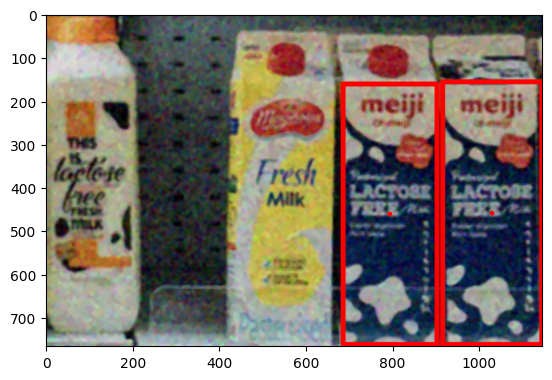

-----------------------------------------------------------------------
-----------------------------------------------------------------------
Searching products in scene  8

Product 23 : 2 instances found:
Instance 1 at  position: (987, 567), width: 325px, height: 870px
Instance 2 at  position: (647, 560), width: 320px, height: 871px

Product 24 : 1 instances found:
Instance 1 at  position: (1336, 580), width: 331px, height: 857px

Product 26 : 1 instances found:
Instance 1 at  position: (256, 590), width: 385px, height: 832px



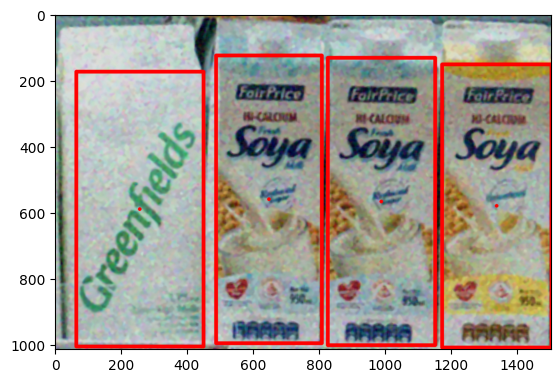

-----------------------------------------------------------------------
-----------------------------------------------------------------------
Searching products in scene  9

Product 19 : 2 instances found:
Instance 1 at  position: (619, 376), width: 225px, height: 557px
Instance 2 at  position: (843, 372), width: 229px, height: 577px

Product 20 : 2 instances found:
Instance 1 at  position: (1363, 377), width: 237px, height: 553px
Instance 2 at  position: (1106, 377), width: 244px, height: 565px



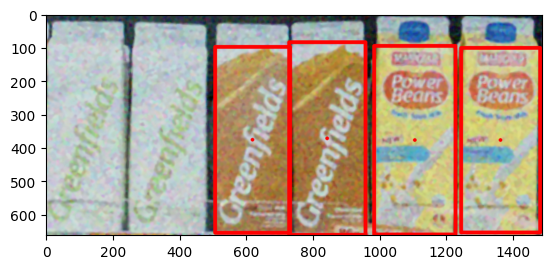

-----------------------------------------------------------------------
-----------------------------------------------------------------------
Searching products in scene  10

Product 22 : 2 instances found:
Instance 1 at  position: (1521, 545), width: 247px, height: 719px
Instance 2 at  position: (1267, 543), width: 247px, height: 724px

Product 21 : 2 instances found:
Instance 1 at  position: (981, 531), width: 249px, height: 702px
Instance 2 at  position: (710, 537), width: 244px, height: 703px



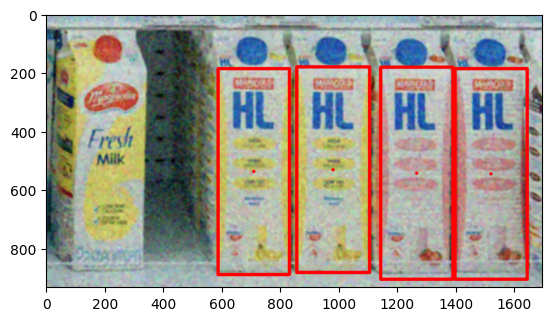

-----------------------------------------------------------------------
-----------------------------------------------------------------------
Searching products in scene  11

Product 25 : 3 instances found:
Instance 1 at  position: (1341, 373), width: 191px, height: 483px
Instance 2 at  position: (1141, 371), width: 190px, height: 495px
Instance 3 at  position: (937, 375), width: 204px, height: 485px

Product 23 : 3 instances found:
Instance 1 at  position: (165, 358), width: 180px, height: 492px
Instance 2 at  position: (356, 356), width: 181px, height: 483px
Instance 3 at  position: (753, 386), width: 199px, height: 545px

Product 24 : 1 instances found:
Instance 1 at  position: (554, 367), width: 187px, height: 481px



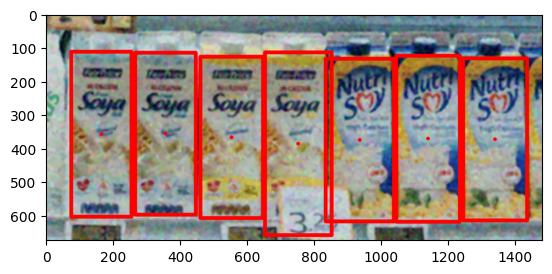

-----------------------------------------------------------------------
-----------------------------------------------------------------------
Searching products in scene  12

Product 18 : 2 instances found:
Instance 1 at  position: (136, 396), width: 260px, height: 613px
Instance 2 at  position: (405, 402), width: 250px, height: 601px



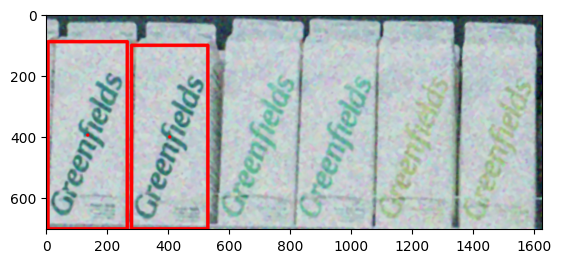

In [34]:
for i, scene in enumerate(scenes[5:]):
  sift = cv2.SIFT_create()
  kp_scene, des_scene = detect_features(sift, scene)
  multiple_detection(i+6, scene, kp_scene, des_scene, refs[14:], sift, 15, 0.59, 0.2, True)